# Выявление закономерностей для успешной игры

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
<br>Цель анализа - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Для выполнения поставленной цели выполним следующие шаги:
1. [Обзор данных](#step1) 
2. [Предобработка данных](#step2)
    * [Перемеинование столбцов](#step2/1)
    * [Изменение типа данных](#step2/2)
    * [Обработка пропусков](#step2/3)
3. [Исследовательский анализ данных](#step3)
4. [Составляем портрет пользователя каждого региона](#step4)
5. [Шаг 5. Проверка гипотез](#step5)
    * [Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#step5/1)
    * [Гипотеза 2 Средние пользовательские рейтинги жанров Action и Sports разные](#step5/2)
6. [Общий вывод](#step6)

## Шаг 1. Обзор данных <a id='step1'></a>

Перед работой имопортируем все необходимые библиотеки.

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 


Прочитаем предоставленные данные.

In [2]:
data = pd.read_csv('/datasets/games.csv')
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таблица содержится данные о продаже игр. Вся информация представлена в 11 столбцах:

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. 

<p> Сразу видно, что в данных есть проблемы с пропусками, некоторые типы не соответсвуют содержащейся информации.

### Вывод

В первом шаге расмотрели содержание датасета. В 11 столбцах представлена информация о продаже различных видеоигр. Уже при первом обзоре видны некоторые проблеммы в данных (пропуски, несоответсвующие форматы данных). Займемся предобработкой данных. 

## Шаг 2. Предобработка данных <a id='step2'></a>

#### Перемеинование столбцов <a id='step2/1'></a>

Для удобства дальнейшей работы приведем названия столбцов к нижнему регистру.

In [4]:
data.columns = map(str.lower, data.columns) #привод к нижнему регистру
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Названия столбцов приведены к нижнему регистру. Теперь разберемся с типами данных.
#### Приведем столбцы к нужному типу <a id='step2/2'></a>

In [5]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Так как при использовании метода dt.year все равно выводится формат int, то просто воспользуемся прямой сменой формата. При этом у нас имеется небольшое количество пропусков. Возможно, информация об играх заполнялась в базе вручную, и некоторые даты были случайно пропущены. Для мультиплатформенных игр даты выхода могут существенно различаться и так как пропусков не много, то удалим их.

In [7]:
#количесво пропусков
print('Процент пропусков:', data['year_of_release'].isna().sum() / len(data) * 100)

data = data.dropna(subset = ['year_of_release']) # удаление пропусков
data['year_of_release'] = data['year_of_release'].astype('int') #переревод в int
data['year_of_release']

Процент пропусков: 1.609332934489979


0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16446, dtype: int64

Переведем рейтинг пользователей в числовой формат.

In [8]:
data.loc[data['year_of_release'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [9]:
try:
    data['user_score'] = pd.to_numeric(data['user_score'])
    data['user_score']
except ValueError as ve:
    print(ve)

Unable to parse string "tbd" at position 119


В столбце не только чистовые значения в виде строк, но и строка tbd, из-за которой произошла ошибка. 
<br>Аббревиатура "tbd" обозначает To Be Determined, то есть "Будет определено". Значит пользовательский рейтинг игры еще не известен. Поэтому можно воспринимать это значение как пропуск.

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'], errors = 'coerce') #в случае ошибки, заменяет значение на NaN

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Все данные имеют ожидаемый формат. Займемся заполнение пропусков.

#### Обработка пропусков <a id='step2/3'></a>

Видно, что в столбце name у нас есть два пропуска. Посмотрим на эти строки.

In [12]:
data.loc[data['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Об этих играх ничего не известно, так что просто удалим эти строки.

In [13]:
data = data.dropna(subset = ['name']) #удаление пустых строк
print('Пропусков после обработки:', data['name'].isna().sum())

Пропусков после обработки: 0


Теперь нам необходимо заполнить пропуски в рейтинге пользователей и критиков. Посчитаем количесво пропусков в каждой категории.

In [14]:
users_na = data['user_score'].isna().sum()
critics_na = data['critic_score'].isna().sum()
print(f'Пропусков в user_score: {users_na}')
print(f'Пропусков в critic_score: {critics_na}')

Пропусков в user_score: 8981
Пропусков в critic_score: 8461


Пропусков разное количесво. Можно предположить, что есть пары, где нехватает только одного рейтинга. Заполним только эти случа, так как мы с большой вероятностью можем предугадать рейтинг.
<br> Для этого разделим сгруппируем рейтинг на группы по распределению:
* очень низкий
* низкий
* средний
* выше среднего
* высокий

Перед группировкой проверим данные на наличие необычных значений.

In [15]:
data[['critic_score', 'user_score']].describe()

,critic_score,user_score
count,7983.000000,7463.000000
mean,68.994363,7.126330
std,13.920060,1.499447
min,13.000000,0.000000
25%,60.000000,6.400000
50%,71.000000,7.500000
75%,79.000000,8.200000
max,98.000000,9.700000


In [16]:
data['critic_score_id'] = pd.cut(data['critic_score'], bins = 5, 
                                 labels = ['очень низкий', 'низкий', 'средний', 'выше среднего', 'высокий'])

data['user_score_id'] = pd.cut(data['user_score'], bins = 5, 
                                 labels = ['очень низкий', 'низкий', 'средний', 'выше среднего', 'высокий'])

Найдем медиану в зависимости мелианальные значения рейтига пользователей в зависимости от сгруппированого рейтинга критиков и жанра.

In [17]:
users_mean_score = data.groupby(['critic_score_id', 'genre']).agg({'user_score': ['median']})
users_mean_score.columns = ['user_score_median']
users_mean_score = users_mean_score.reset_index()
users_mean_score.head()

,critic_score_id,genre,user_score_median
0,очень низкий,Action,3.4
1,очень низкий,Adventure,2.5
2,очень низкий,Fighting,3.0
3,очень низкий,Misc,4.3
4,очень низкий,Platform,2.7


In [18]:
#соединим таблицы
data = data.merge(users_mean_score, on = ['critic_score_id', 'genre'], how = 'left')
data.shape 

(16444, 14)

In [19]:
data.loc[(data['critic_score'].isna() == False) &  (data['user_score'].isna() == True)].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_id,user_score_id,user_score_median
182,Tomb Raider II,PS,1997,Action,2.30,2.46,0.2,0.28,85.0,NaN,T,высокий,NaN,8.2
300,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,NaN,E10+,средний,NaN,6.2
438,Need for Speed III: Hot Pursuit,PS,1998,Racing,2.14,0.86,0.0,0.13,88.0,NaN,E,высокий,NaN,8.2
631,Riven: The Sequel to Myst,PC,1997,Adventure,1.52,0.82,0.0,0.10,83.0,NaN,E,высокий,NaN,8.6
639,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,NaN,E,выше среднего,NaN,7.4


In [20]:
data.loc[(data['critic_score'].isna() == False) &  (data['user_score'].isna() == True), 'user_score'] = (
data.loc[(data['critic_score'].isna() == False) &  (data['user_score'].isna() == True), 'user_score_median'])

In [21]:
data.loc[[182, 300]]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_id,user_score_id,user_score_median
182,Tomb Raider II,PS,1997,Action,2.30,2.46,0.2,0.28,85.0,8.2,T,высокий,NaN,8.2
300,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,6.2,E10+,средний,NaN,6.2


Проверим, есть ли пары, в которой имеется user_score  и пропуск в critic_score

In [22]:
data.loc[(data['critic_score'].isna() == True) &  (data['user_score'].isna() == False)].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_id,user_score_id,user_score_median
254,Call of Duty: Advanced Warfare,PS3,2014,Shooter,1.56,1.93,0.19,0.68,NaN,4.8,M,NaN,средний,NaN
262,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,NaN,4.9,M,NaN,средний,NaN
263,FIFA 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,NaN,4.5,E,NaN,средний,NaN
290,World Soccer Winning Eleven 9,PS2,2005,Sports,0.12,2.26,0.90,0.77,NaN,8.2,E,NaN,высокий,NaN
358,Just Dance 2014,Wii,2013,Misc,1.88,1.39,0.00,0.31,NaN,6.2,E10+,NaN,выше среднего,NaN


In [23]:
critic_score_mean = data.groupby(['user_score_id', 'genre']).agg({'critic_score': 'median'})
critic_score_mean.columns = ['critic_score_median']
critic_score_mean.reset_index(inplace = True)
critic_score_mean.head()

,user_score_id,genre,critic_score_median
0,очень низкий,Action,38.0
1,очень низкий,Adventure,34.0
2,очень низкий,Fighting,28.0
3,очень низкий,Misc,34.0
4,очень низкий,Platform,45.0


In [24]:
data = data.merge(critic_score_mean, on = ['user_score_id', 'genre'], how = 'left')
data.shape

(16444, 15)

In [25]:
data.loc[(data['critic_score'].isna() == True) &  (data['user_score'].isna() == False), 'critic_score'] = (
data.loc[(data['critic_score'].isna() == True) &  (data['user_score'].isna() == False), 'critic_score_median'])

Выведим информацию о пропусках в этих данных

In [26]:
data[['critic_score', 'user_score']].isna().sum()

critic_score    7894
user_score      7892
dtype: int64

Осталось незаполнено два значения

In [27]:
data.loc[(data['critic_score'].isna() == True) &  (data['user_score'].isna() == False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_id,user_score_id,user_score_median,critic_score_median
9540,Are You Smarter than a 5th Grader? Game Time,X360,2009,Puzzle,0.12,0.0,0.0,0.01,NaN,1.3,E,NaN,очень низкий,NaN,NaN
12825,Myth Makers: Orbs of Doom,Wii,2007,Puzzle,0.05,0.0,0.0,0.00,NaN,1.1,E,NaN,очень низкий,NaN,NaN


Не хватило значений для подсчета медианы. Просто заполним пропуск пользовательским рейтингом.

In [28]:
data.loc[(data['critic_score'].isna() == True) &  (data['user_score'].isna() == False), 'critic_score'] = \
data.loc[(data['critic_score'].isna() == True) &  (data['user_score'].isna() == False), 'user_score']

In [29]:
data[['critic_score', 'user_score']].isna().sum()

critic_score    7892
user_score      7892
dtype: int64

Остальные пропуски в этих колонках нет возможности доставерно заполнить. Заполнение медианой может отрицательно повлиять на корреляцию. Поэтому оставим пропуски незаполненными.

Теперь займемся пропусками в колонке rating. У игр одного жанра с высокой долей вероятности будет похожий рейтинг. Заполним пропуски часто встречающимися значениями рейтинга для каждого жанра.

In [30]:
grp = data.groupby('genre')['rating'].apply(lambda x: x.mode().iloc[0])
genre_mode = grp.reset_index()
genre_mode.rename(columns = {'rating': 'rating_mode'}, inplace = True)
data = data.merge(genre_mode, on = ['genre'], how='left')
data.shape

(16444, 16)

In [31]:
data.loc[data['rating'].isna(), 'rating'] = data.loc[data['rating'].isna(), 'rating_mode']

In [32]:
print('Пропусков после обработки:', data['rating'].isna().sum())

Пропусков после обработки: 0


Оставим только необходимые для работы столбцы, и проверим данные

In [33]:
data = data.iloc[:, 0:11]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       8552 non-null float64
user_score         8552 non-null float64
rating             16444 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Остались только пропуска в оценках пользователей и критиков. Их не убираем, как проговоривали выше.
<br>Посчитаем суммарные продажи во всех регионах и запишите их в отдельный столбец *total_sales*

In [34]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,E,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T,31.38


В завершение проверим данные на дубликаты.

In [35]:
data.duplicated().sum()

0

### Вывод

Произвели предварительную обработку данных. Перемеиновали столбцы в более удобный формат и поменяли типы данных, которые несоответсвовали содержимому (перевели пользовательский рейтинг из object в float и год реализации в формат int). В данных содержалось большое количесво пропусков, которые пришлось обработать. Строки с пропусками в столбцах *name* и *year_of_release* удали, так как их очень малое количесво (менее 2%). В столбцах с рейтингом критиков и пользователе заполнили не все пропуски, а где есть хотя бы один вид оценки. В рейтинге ESRB содержались неопределнные значения. Их заменили на NaN и пропуски заполнили самыми встречаемыми рейтингами для определнного жанра. В итоге, данные готова к исследовательскому анализу.

## Шаг 3. Исследовательский анализ данных <a id='step3'></a>

Приступим к исследовательскому анализу данных. Посмотрим, сколько игр выпускалось в разные годы. Для этого построим график.

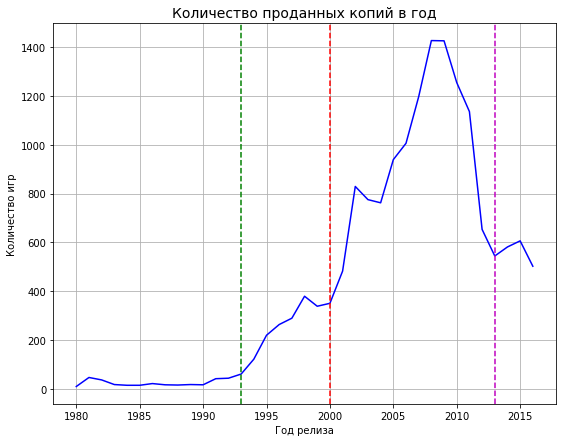

In [36]:
games_per_year = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')

plt.figure(figsize = (9, 7))
plt.plot(games_per_year, color = 'b')
plt.grid()
plt.title('Количество проданных копий в год', size = 14)
plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.axvline(2000, c='r', ls='--')
plt.axvline(1993, c='g', ls='--')
plt.axvline(2013, c='m', ls='--')

По графику видно, что начиная с 1993 года начинает расти количесво выпускаемых игр. В 2000 году начинается резкий подъем выпуска игр и достигает своего пика в 2007-2008 году. Такой рост связан с резким распространениям игровых приставок и компьютеров у людей.После индустрия идет на спад. В 2013 наблюдается рост. Скорее всего это выход PS4 И XOne. 
<br> Для определения актуального периода, постотрим как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и постройте распределение по годам. Возьмем топ 10 по проданным копиям за все время.

In [37]:
platform = data.groupby('platform')['total_sales'].agg('sum').sort_values(ascending = False)
platform = platform.head(10)
platform

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

In [38]:
platforms = platform.index.tolist()

In [39]:
data1 = data.loc[data['platform'].isin(platforms)]
data.shape

(16444, 12)

In [40]:
group_platform = data1.groupby(['year_of_release', 'platform'])['total_sales'].agg('sum')
group_platform = group_platform.reset_index(level = 'platform')
group_platform.head()

,platform,total_sales
year_of_release,,
1985,DS,0.02
1994,PS,6.03
1995,PS,35.96
1996,PS,94.70
1997,PS,136.17


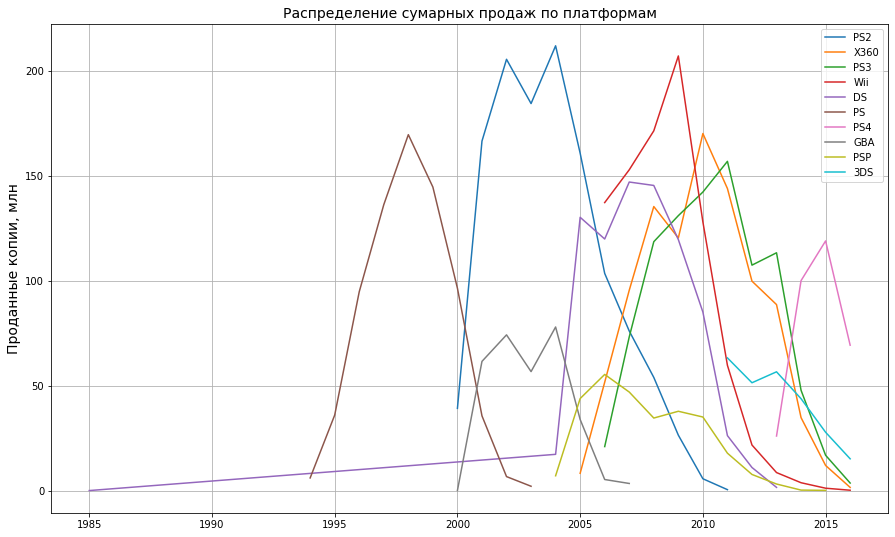

In [41]:
plt.figure(figsize = (15, 9))
for platform in platforms:
    plt.plot(group_platform.loc[group_platform['platform'] == platform, 'total_sales'], label = platform)
    plt.legend()
plt.grid()
plt.title('Распределение сумарных продаж по платформам', size=14)
plt.ylabel('Проданные копии, млн', size = 14)
plt.show()

Как можно видеть по графику, что одна платформа в среднем проживает 8 лет. Новые платформы появляюся с пятилетним интервалом. Исчезают платформы дольше, что видно по более пологим хвостам распределений. Люди продолжают пользователься старыми приставками в течении некоторго времени. Можно наблюдать, что главные конкуренты появляются и пропадают примернго в одно время (X-box 360 и PS3).

<br> Так как судя по графику общей продажи в 2013 вышли приставки нового поколения, будем проводить анализ с 2013 года. Это даст возможность проанализирвоать затухающие приставки и новых игроков рынка.

In [42]:
data = data.query('year_of_release >= 2013') #продажи после 2013 года
data.shape

(2233, 12)

Посомотрим, какие платформы лидируют по общим продажам в актуальный период. Выведим ТОП5.

In [43]:
data.groupby('platform')['total_sales'].agg('sum').sort_values(ascending = False).head()

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
Name: total_sales, dtype: float64

Лидируют в общих продажах приставики от SONY и Xbox ONE. В целом, данные ожидаемые.
<br>Посмотрим динамику продаж по годам. Для этого постоим график.

In [44]:
group_platform = data.groupby(['year_of_release', 'platform'])['total_sales'].agg('sum')
group_platform = group_platform.reset_index(level = 'platform')

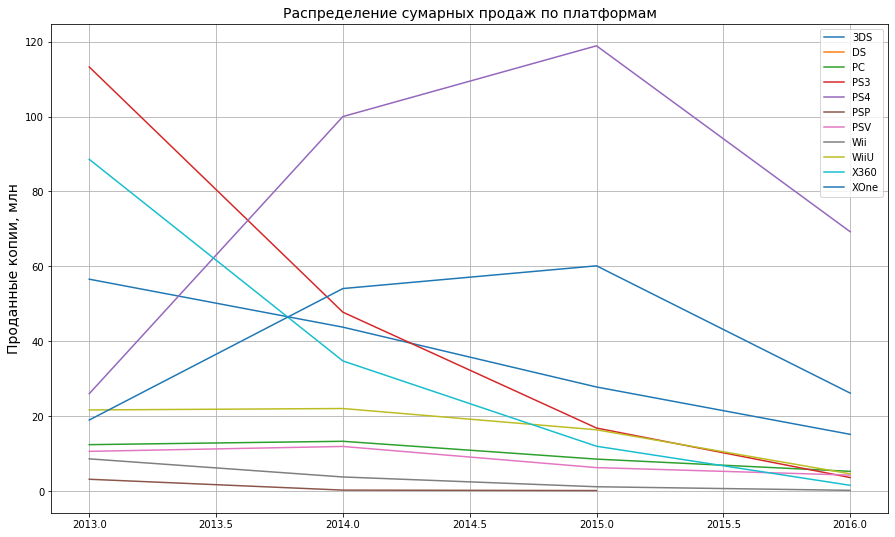

In [45]:
plt.figure(figsize = (15, 9))
for platform in group_platform['platform'].unique():
    plt.plot(group_platform.loc[group_platform['platform'] == platform, 'total_sales'], label = platform)
    plt.legend()
plt.grid()
plt.title('Распределение сумарных продаж по платформам', size=14)
plt.ylabel('Проданные копии, млн', size = 14)
plt.show()

Видим, что суммарные по всем платформам падают. В первые 2 года после выхода приставок нового поколения суммарные продажи росли, но после интерес упал. Для PC и PSV виден стабильный спрос. 3Ds и WiiU еще покупают, но видна отрицательная динамика. PS2, X360 и Wii уже абсолютно не актуальны.
<br> Выведим Топ 5 платформ по суммарным продажам за 2016 год.

In [46]:
group_platform.reset_index()[group_platform.reset_index()['year_of_release'] == 2016].sort_values(by = 'total_sales',
                                                                                                 ascending = False).head()

,year_of_release,platform,total_sales
34,2016,PS4,69.25
39,2016,XOne,26.15
31,2016,3DS,15.14
32,2016,PC,5.25
37,2016,WiiU,4.60


Таким образом, данные 5 платформ будут наиболее прибыльными в 2017 году. Особенно PS4 и XOne, так как тенденция снижения суммарных продаж постепенно снижается.

In [47]:
platforms = ('PS4', 'XOne', '3DS', 'PC', 'WiiU')
data = data.loc[data['platform'].isin(platforms)]
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,M,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,T,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,T,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
...,...,...,...,...,...,...,...,...,...,...,...,...
16389,Prison Architect,XOne,2016,Action,0.01,0.00,0.00,0.00,74.0,6.7,T,0.01
16397,Fujiko F. Fujio Characters: Great Assembly! Sl...,3DS,2014,Action,0.00,0.00,0.01,0.00,NaN,NaN,T,0.01
16401,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01
16406,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,T,0.01


Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

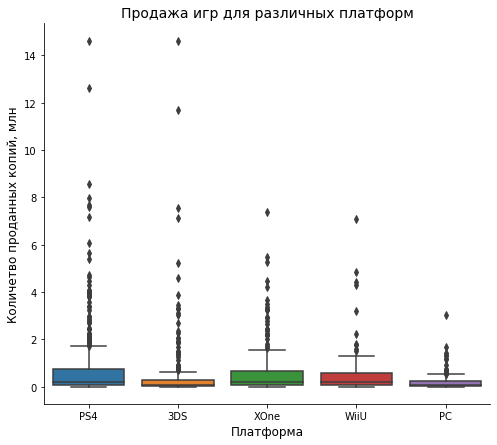

In [48]:
plt.figure(figsize=(8, 7))
sns.boxplot(x = 'platform', y = 'total_sales', data=data)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Продажа игр для различных платформ', size = 14)
plt.xlabel('Платформа', size = 12)
plt.ylabel('Количетво проданных копий, млн', size = 12)
plt.show()

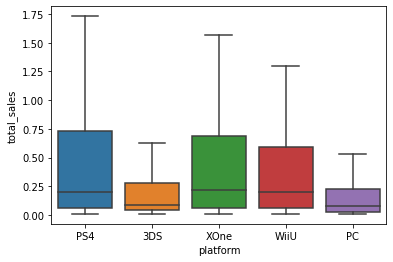

In [49]:
sns.boxplot(x = 'platform', y = 'total_sales', data=data, showfliers=False)

Количество проданных копий на всех платформах имеет тяжелый хвост. Есть очень большое количество популярных игр на каждой платформе. При этом у нас много выбросов.  Можно предположить, что это особые бестселлеры и эксклюзивы для приставок. Так как эти выбросы получились не случайно, то оставим их, иначе потеряем информацию о самых продаваемых играх.

Посмотрим, как влияют на продажи отзывы пользователей и критиков. Для этого построим диаграммы рассеивания и посчитаем корреляции. Анализ проведем на самом популярной платформе - PS4.

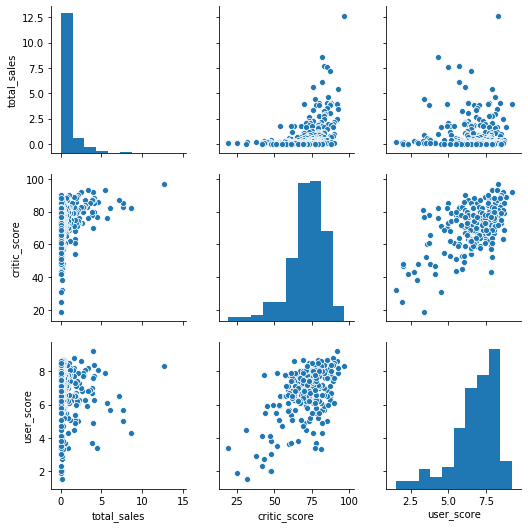

In [50]:
sns.pairplot(data.loc[data['platform'] == 'PS4', ['total_sales', 'critic_score', 'user_score']]);

По диаграмм рассеивания видна положительная корреляция между продажами и оценками критиками. Расчитаем числовые значения.

In [51]:
data.loc[data['platform'] == 'PS4', ['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.405601,-0.034946
critic_score,0.405601,1.000000,0.562603
user_score,-0.034946,0.562603,1.000000


Для PS4 наблюдается средняя линейная взаимосвязь между продажами и рейтингом критиков. При этом связь между продажами и оценками пользователей не наблюдается. Есть связь между оценками критиками и оценками пользователей. Тут выступает третий фактор, такой как качество самой игры.
<br> Посмотрим на другие популярные платформы.

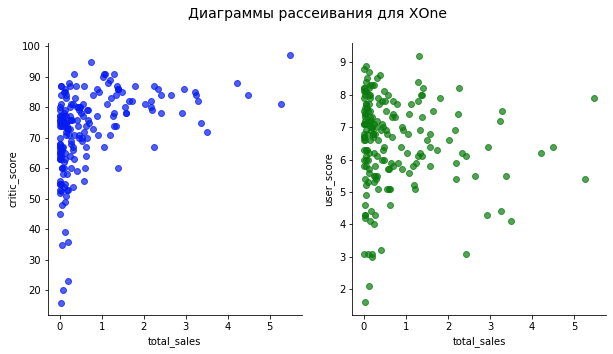

Матрица корреляции для XOne


,total_sales,critic_score,user_score
total_sales,1.000000,0.408484,-0.070712
critic_score,0.408484,1.000000,0.517149
user_score,-0.070712,0.517149,1.000000


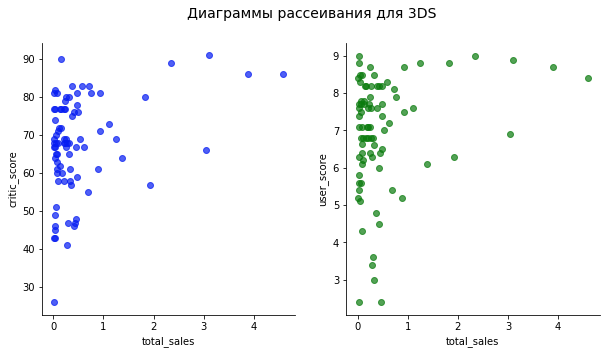

Матрица корреляции для 3DS


,total_sales,critic_score,user_score
total_sales,1.000000,0.334423,0.244069
critic_score,0.334423,1.000000,0.757582
user_score,0.244069,0.757582,1.000000


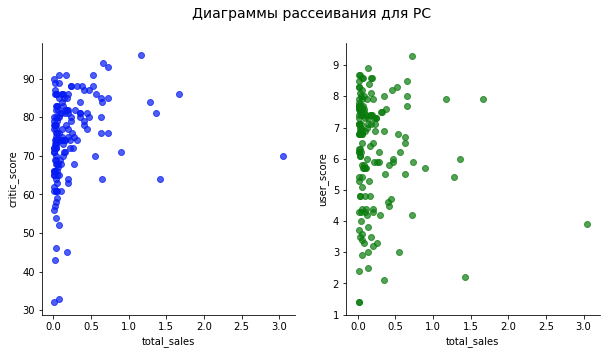

Матрица корреляции для PC


,total_sales,critic_score,user_score
total_sales,1.000000,0.211168,-0.095950
critic_score,0.211168,1.000000,0.465622
user_score,-0.095950,0.465622,1.000000


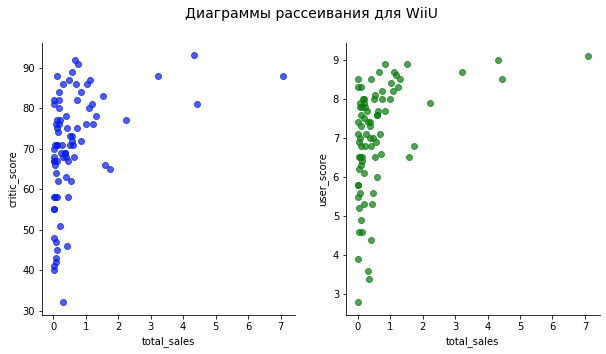

Матрица корреляции для WiiU


,total_sales,critic_score,user_score
total_sales,1.000000,0.393903,0.413923
critic_score,0.393903,1.000000,0.732174
user_score,0.413923,0.732174,1.000000


In [52]:
platforms = ('XOne', '3DS', 'PC', 'WiiU')

for platform in platforms:
    plt.figure(figsize = (10, 5))
    plt.suptitle(f'Диаграммы рассеивания для {platform}', size = 14)  
    plt.subplot(1, 2, 1)
    plt.scatter(x = data.loc[data['platform'] == platform, 'total_sales'], 
                y = data.loc[data['platform'] == platform, 'critic_score'], color='#051BF2', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('total_sales')
    plt.ylabel('critic_score')
    plt.subplot(1, 2, 2)
    plt.scatter(x = data.loc[data['platform'] == platform, 'total_sales'], 
                y = data.loc[data['platform'] == platform, 'user_score'], color = '#0A7B0D', alpha=0.7)
    plt.xlabel('total_sales')
    plt.ylabel('user_score')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    print(f'Матрица корреляции для {platform}')
    display(data.loc[data['platform'] == platform, ['total_sales', 'critic_score', 'user_score']].corr())


Для разных популярных платформ мы видим различную силу связи между числом проданных копий и отзывами. Для XOne, так же как для PS4 наблюдается средняя линейная взаимосвязь между продажами и рейтингом критиков. Cвязь между продажами и оценками пользователей не наблюдается. У 3Ds платформы связь между оценками критиков и прожажами снижается, но растет взаимодейсвие с оценками пользователей. Рейтинг критиков для PC слабо связан с объесмом продаж. Для WiiU мы видим противоположную картину. В отличии от других платформ, имеется почти равная средняя связь между продажами и отзывами критиков, и отзывами пользователей.

Выясним, какие жанры являются самыми прибыльными для всех платформ.

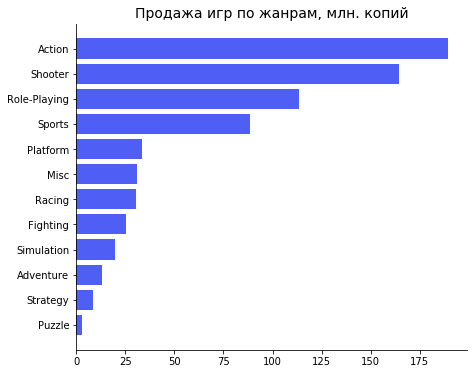

In [53]:
genres = data.pivot_table(index = ['genre'], values = 'total_sales', aggfunc = 'sum') #суммарные продажи для каждого жанра
genres = genres.sort_values('total_sales', ascending = True)

plt.figure(figsize = (7, 6))
plt.title('Продажа игр по жанрам, млн. копий', size = 14)
plt.barh(genres.index, genres['total_sales'], color = '#051BF2', alpha = 0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Самые прибыльные жанры это Action, Shooter, RPG и Sport. Это самые зрелищные и высокобюджетные игры, механика котрых заточена для игр с гемпадами. Скорее всего именно эти жанры покупают для игры на приставках нового поколения. Наименьшей популярность пользуются спокойные игры, такие как стратегии и разлы.
<br> Посмотрим как распределены прибыли по жанрам относительно платформ.

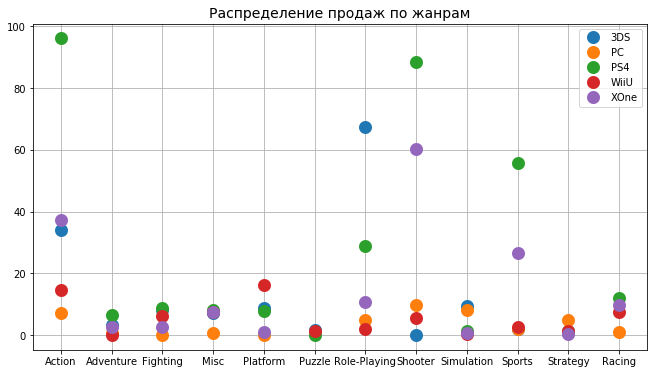

In [54]:
genres = data.pivot_table(index = ['genre', 'platform'], values = 'total_sales', aggfunc = 'sum')
genres = genres.reset_index(level = 'platform')

plt.figure(figsize = (11, 6))
plt.title('Распределение продаж по жанрам', size = 14)
for platform in genres['platform'].unique():
    plt.plot(genres.loc[genres['platform'] == platform, 'total_sales'], 'o', mew = 7, label = platform, )
    plt.legend()
plt.grid()
plt.show()

Действительно, самые продаваемые жанры для PS4 и XOne - Action и Shoter. Но стоит заметить, что продажи для PS4 b XOne зеркальны. Пользователи 3Ds в больше всего покумают RPG.

### Вывод

В этом шаге провели исследовательский анализ данных. На основе информации о продажах игр выяснили, что средний период жизни для игровой приставки - 8 лет. Изучили динамику продаж игр, и взяли за начало актуального периода 2013 год, так как в этот год резко возрасли продажи, в связи с выходом PS4 и Xbox One. В 2017 году это будут самые востребованные приставки. Также люди активно пользуются Nintendo 3DS. PC в виду своей универмальности, также пользуются спросом, и на протяжении всего времени имеетт стабильную аудиторию. 
<br> Распределение продаж для всех платформ скошено вправо. При этом имеется большое количестов выбросов, тоесть иногда выходят очень популярные игры.
<br> Продажи для PS4 и XOne имееют среднюю связь с отзывами критков и абсолютно не связаны с рейтинком пользователей. Продажи игр на PC очень слабо коррелируют с рейтингом критиков. Для 3Ds имеется слабая связь и между и с оценкой критиков и с оценокй пользователей. Противоволожную картину мы видим для WiiU. Продажи игр сильнее связаны с оценками пользователей, а для оценки критиков корреляция ниже.
<br> В целом, самым популрным жаром является Action. Самые низкие продажи имеют Пазлы. При этом для разных приставок самые продаваемые жанры отличаются. Для PS4 это Action, XOne - Shooter, а 3Ds - RPG.

### Шаг 4. Составляем портрет пользователя каждого региона <a id='step4'></a>

Посмотрим, как различаются самые популярные платформы в различных регионах. Оценить доли каждой страны, посторим столбчатые диаграммы с накоплением.

In [55]:
platform = data.pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
platform

,eu_sales,jp_sales,na_sales
platform,,,
3DS,30.96,67.81,38.20
PC,25.36,0.00,11.11
PS4,141.09,15.96,108.74
WiiU,19.85,10.88,29.21
XOne,51.59,0.34,93.12


In [56]:
#постороение диаграммы с накоплением
def stacked_bar_chart(pivot, title = 'Распределение популярности по регионам'):
    x = pivot.index
    indexes = np.argsort(pivot.values).T
    widths = np.sort(pivot.values).T
    order = -1
    lefts = widths[::order].cumsum(axis=0)
    lefts = np.insert(lefts, 0, np.zeros(len(lefts[0])), axis=0)

    mpp_colors = dict(zip(pivot.columns, plt.cm.get_cmap("tab10").colors))
    fig, ax1 = plt.subplots(figsize = (7, 5))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    for k, (idxs, vals) in enumerate(list(zip(indexes, widths))[::order]):
        mps = np.take(np.array(pivot.columns), idxs)
        ax1.barh(x, width=vals, left=lefts[k], color=[mpp_colors[m] for m in mps])

    ax1.legend((np.take(np.array(pivot.columns), np.argsort(pivot.values)[0]))[::-1], 
           bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.title(title, size = 14);

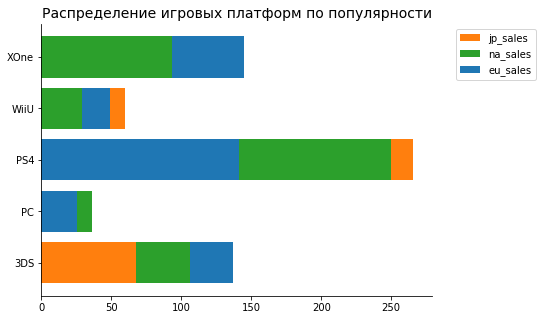

In [57]:
stacked_bar_chart(platform, 'Распределение игровых платформ по популярности')

Продажи игр для разных присатавок зависят от стран. 3DS наиболее популряна в японии, XOne самая популярная приставка в Северной Америка, PS4 покупают в Европе.

<p> Теперь посмотрим распределние по самым  популярным жанрам.

In [58]:
#выделение максимального значения 
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
    
genre = data.loc[data['genre'].isin(['Action', 'Shooter', 'Role-Playing', 'Sports', 'Platform'])] #Отбор сета по ТОП5
genre_grp = genre.pivot_table(index='genre', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
genre_grp.style.apply(highlight_max)

,eu_sales,jp_sales,na_sales
genre,,,
Action,71.98,24,72.43
Platform,11.99,4.71,14.02
Role-Playing,30.96,38,36.35
Shooter,64.34,4.51,74.85
Sports,37.91,2.34,36.74


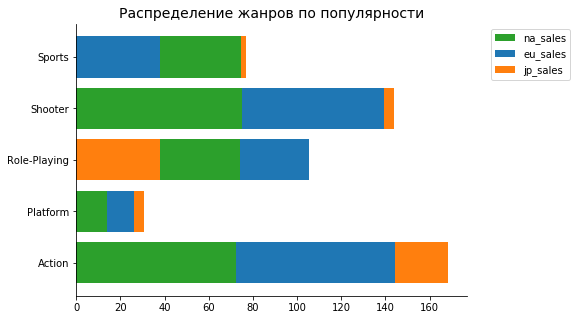

In [59]:
stacked_bar_chart(genre_grp, 'Распределение жанров по популярности')

В разных странах пердпочтения по играм так же отличаются. Так RPG - самый популярный жанр в Японии. В европе больше покупают Action, а в Соединенных штатах играют в Shooter. При этом, в целом доля покупок в США для Action и Shooter выше чем в остальных странах. Также в Европе и США пользуются попуялность спортивные игры, которые в основном выходят на PS4 и XBox.

Оценим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [60]:
rating = data.pivot_table(index = 'rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
rating.style.apply(highlight_max)

,eu_sales,jp_sales,na_sales
rating,,,
E,73.94,23.47,63.11
E10+,25.05,5.38,31.85
M,108.65,7.38,113.08
T,61.21,58.76,72.34


Так как и рейтинг игры и старана это категориальные оценки, то зависимость между критериями проверим с помощью критерия Хи-квадрат Пирсона. 
Нулевая гипотеза: рейтинг игры и страна покупки независимы.
Альтернативная: есть связь между страной покупки игры и рейтингом ESRB

In [61]:
st.chi2_contingency(rating)

(66.67939549561252,
 1.957421326834841e-12,
 6,
 array([[66.98923039, 23.66861445, 69.86215516],
        [25.9910869 ,  9.18316289, 27.10575021],
        [95.61364674, 33.7821845 , 99.71416876],
        [80.25603598, 28.35603815, 83.69792586]]))

P уровень значимости почти равен 0, можем отбросить нулевую гипотезу, и считать, что рейтинг игры и количество проданных копий для разных стран связаны.
Тогда можно утверждать, что в Европе и США больше покупают игры с рейтингом M, а в Японии берут инры с рейтингом T. Но эта связь может быть связана с тем, что игры одного жанра имеют похожий рейтинг.

### Вывод

По имеющимся данным составили портрет пользователя для каждого региона.
Так в Японии люди больше всего играют в RPG c рейтингом T ESRB на 3DS. Европейца предпочитают Action c ESRB M для PS4, а в Соединенных штатат играют в Шутеры c ESRB M, при этом и на PS4 и на XBOX.

## Шаг 5. Проверка гипотез <a id='step5'></a>

**Гипотеза 1.** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. <a id='step5/1'></a>
<p>Проверим гипотезу о том, что рейтинги пользователей для разных платформ одиноковые.
<br> для проверки данной гипотезы воспользается t-критерией для независимых выборок. Так как нет уверенности в равенсве дисперсий, то будем проводить тест Велча.
<br> Нулевая гипотеза (H0): средние рейтиги для для Xbox One и PC равны
<br> Альтернативня гипотеза (H1): средние рейтинги отличаются.
<br> Примем уровень значимости alpha = 0,05

In [62]:
#удалит пропуски для проведения t-теста
pc = data.query('platform == "PC"')['user_score'].dropna() 
xone = data.query('platform == "XOne"')['user_score'].dropna()

alpha = .05
results = st.ttest_ind(pc, xone, equal_var = False)

print('p-значение:', results.pvalue)
print('t-критерий:', results.statistic)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14795785739168363
t-критерий: -1.450607818458426
Не получилось отвергнуть нулевую гипотезу


У нас достаточных оснований отвегать нулевую гипотезу. Поэтому, можем считать, что выдвинутая нами гипотеза подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Гипотеза 2** Средние пользовательские рейтинги жанров Action и Sports разные. <a id='step5/2'></a>
<p> Для проверки гипотезы снова воспользуемся тестом Велча.
<br> Нулевая гипотеза (H0): Для разных жанров средние рейтинги равны.
<br> Альтернативная гипотеза (H1): Средние рейтинги различаются
<br> Примем уровень значимости alpha = 0,05

In [63]:
action = data.query('genre == "Action"')['user_score'].dropna()
sport = data.query('genre == "Sports"')['user_score'].dropna()

alpha = .05
test = st.ttest_ind(action, sport, equal_var = False)

print('p-значение:', test.pvalue)
print('t-критерий:', test.statistic)
if (test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.9014872547492414e-11
t-критерий: 7.1282032264658595
Отвергаем нулевую гипотезу


Можем отвергуть нулевую гипотезу. Гипотеза 2 подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные. При этом по знаку t-критерия можем сказать, что у жанра Action средний рейтиинг выше, чем у жанра Sports.

### Вывод

Проверили две гипотезы о равенстве среднего пользовательского рейтинга для XOne и PC и различии рейтингов для жанра Action и Sports. Обе гипотезы подтвердились.  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Средние пользовательские рейтинги жанров Action и Sports разные. Причем средний рейтинг для жанра Action выше.

## Общий вывод <a id='step6'></a>

Провели анализ продаж игр и выяснили закономерности, которые помогут определить успех игры. Перед делом провели предварительную обработку данных, перемеиновали столбцы, заменили типы данных на ожидаемые и разобрались с пропусками. После этого преступили к анализу.
<br> В ходе исследовательского анализа данных был выявлен срок жизни приставок и выбран актуальный для прогноза период. Работаем с данными с 2013 года, так как в этот год вышли приставки нового поколения, и это дает возможность рассомтреть и затухающие приставки и новых игроков рынка. Наиболее актуальныыми приставками в 2017 году будут PS4, Xbox ONE и 3DS. У всех этих платформ выявлена средняя взаимосвязь между рейтингом критиков и продажей игр. Низкая связь с пользовательским рейтинком есть только у продаж 3DS. Наблюдаются различные предпостения в приставках у людей из разных стран. PS4 одинаково хорошо продается и в США и Европе, XOne больше покупают в США, а 3DS а Японии.
<br> Action, Shooter и RPG являются сами популярными жанрами. Опять же, в разных странах предпочтения различаются. В Европе лучше продаются Экшены, в США Шутеры а в Японии RPG. Несмтря на такое предпочтение, американский рынок лидирует по продажам и в сегменте Экшена и Шутеров. Популярность в Европе и США пользуется и жанр Sports, преимущесвено выходящий на PS4 и Xbox.
<br> Найдена связь между рейтингом игр и продажами в разных странах. Но эта связь скорее объясняется тем, что игры одного жанра имеют похожий рейтинг.
<br> В ходе исследования рынка проверили две гипотезы. Первая, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Вторая, что средние пользовательские рейтинги жанров Action и Sports разные. Обе гипотезы подтвердились.
<br> Наиболее успешными играми будут Экшены и Шутеры для PS4 и XOne, а также будут довольно популярными RPG для всех платформ. На Европейском и Американском рынке также популярными остануться спортивные игры для PS4 и XOne.